In [1]:
%matplotlib notebook

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

Niels made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [3]:
import os
import torch
from PIL import Image
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir: Path, train: bool = True, transform = None, num_labels = 150):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        task = 'training' if train else 'validation'
        
        self.images = list((root_dir / 'images' / task).glob('*.jpg'))
        self.images.sort()
        self.annotations = list((root_dir / 'annotations' / task).glob('*.png'))
        self.annotations.sort()
        self.transform = transform
        self.num_labels = num_labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]))
        mask = np.array(Image.open(self.annotations[idx]))
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        # convert to C, H, W
        image = image.transpose(2,0,1)
        return image, mask
        
        

We can defined two data augmentations, one for training and one for validating. We used [albumentations](https://albumentations.ai/docs/).

In [4]:
#!pip install -U albumentations

Let's create our data pipelines

In [5]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=640, height=640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

valid_transform = A.Compose([
    A.Resize(width=1024, height=1024),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

Let's initialize the training + validation datasets:

In [6]:
root_dir = Path('./ADE20k_toy_dataset/')

train_dataset = ImageSegmentationDataset(root_dir=root_dir, transform=train_transform)
# we will still use the images in train folder for this example since our goal is to showcase how to use it, thus 
# we will overfit the train dataset
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, transform=valid_transform)

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's also get the labels from our hub

In [8]:
import json
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url

repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = { int(k): v for k, v in id2label.items() }
label2id = { v: k for k, v in id2label.items() }

Let's visualize some of the masks, you can use the following interact cell to select the dataset index and one of the binary masks using their class label!

In [9]:
# !pip install ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
%matplotlib notebook

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


vis_dataset = ImageSegmentationDataset(root_dir=root_dir)

def show_ds(idx):
    image, mask = vis_dataset[idx]
    image = image.transpose(1, 2, 0)
    labels = np.unique(mask)
    # 0 is background, so we need to remove -1 from out id2label!
    label2id = {id2label[k - 1] : k for k in labels if k != 0}
    labels_dropdown = widgets.Dropdown(options=label2id.keys())
   
    def show_mask(*args):
        ax2.imshow(mask == label2id[labels_dropdown.value])
   
    fig, (ax1, ax2)  = plt.subplots(ncols=2)
    ax1.imshow(image)
    label_id = label2id[labels_dropdown.value]
    mask_label_id = mask == label_id
    ax2.imshow(mask_label_id.squeeze())
    
    labels_dropdown.observe(show_mask, 'value')

    return labels_dropdown
   


interact(show_ds, idx=range(len(vis_dataset)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()),…

<function __main__.show_ds(idx)>

Let's define our two dataloader with a custom `collate_fn`. We are using `MaskFormerFeatureExtractor.encode_inputs` the encode our inputs, under the hook all segmentastion maps will be converted to binary masks.

In [11]:
from transformers import MaskFormerFeatureExtractor
from torch.utils.data import DataLoader

feature_extractor = MaskFormerFeatureExtractor(size_divisibility=32, ignore_index=255, reduce_labels=True, max_size=1333)

def collate_fn(batch):
    inputs = list(zip(*batch))
    pixel_values = inputs[0]
    segmentation_maps = inputs[1]
    batch = feature_extractor.encode_inputs(
        pixel_values,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )
    
    return batch
    
def valid_collate_fn(batch):
    inputs = list(zip(*batch))
    pixel_values = inputs[0]
    segmentation_maps = inputs[1]
    batch = feature_extractor.encode_inputs(
        pixel_values,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )
    # for val, we also need the original images
    batch["segmentation_maps"] = torch.stack(
        [torch.from_numpy(segmentation_map) for segmentation_map in segmentation_maps]
    )
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=valid_collate_fn, batch_size=4, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, collate_fn=valid_collate_fn, batch_size=1, num_workers=4)

In [12]:
batch = next(iter(train_dataloader))

batch["pixel_values"].shape, batch["mask_labels"][0].shape, batch["class_labels"][0].shape

(torch.Size([4, 3, 640, 640]), torch.Size([15, 640, 640]), torch.Size([15]))

## Define the model

Here we load the model

In [13]:
from transformers import MaskFormerForInstanceSegmentation

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-ade")

/home/zuppif/Documents/Work/hugging_face/transformers/.venv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epoch_bar = tqdm(range(100))
for epoch in epoch_bar: 
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # training loop
    for idx, batch in enumerate(train_dataloader):
        # send inputs to device
        pixel_values = batch["pixel_values"].to(device)
        mask_labels = [el.to(device) for el in batch["mask_labels"]]
        class_labels = [el.to(device) for el in batch["class_labels"]]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model(
            pixel_values=pixel_values,
            mask_labels=mask_labels,
            class_labels=class_labels,
        )
        #  backward
        loss = outputs.loss
        loss.backward()
        # optimize
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= (idx + 1)
    model.eval()
    # validation loop
    for idx, batch in enumerate(valid_dataloader):
        with torch.no_grad():
            segmentation_maps = batch["segmentation_maps"].cpu()
            pixel_values = batch["pixel_values"].to(device)
            # forward
            outputs = model(pixel_values=pixel_values)

            semantic_segmentation = (
                feature_extractor.post_process_semantic_segmentation(
                    outputs, target_size=segmentation_maps.shape[1:]
                )
            )
            # reduce the labels
            segmentation_maps[segmentation_maps == 0] = 255
            segmentation_maps -= 1
            segmentation_maps[segmentation_maps == 254] = 255
            
            semantic_segmentation = semantic_segmentation.cpu()
            # we don't care about background
            not_count = semantic_segmentation != 255
            accuracy = (
                semantic_segmentation[not_count] == segmentation_maps[not_count]
            ).sum() / segmentation_maps[not_count].numel()
            epoch_accuracy += accuracy.item()

    epoch_accuracy /= (idx + 1)
    epoch_bar.set_postfix({"loss" : epoch_loss, "accuracy": epoch_accuracy})


    
torch.save(model.state_dict(), "model.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

# Inference
Let's see how we can easily visualize the results from the model

In [15]:
image, mask = valid_dataset[0]

with torch.no_grad():
    inputs = feature_extractor(image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    outputs = model(pixel_values)
    semantic_segmentation = feature_extractor.post_process_semantic_segmentation(outputs, target_size=mask.shape)

Let's see the target segmentation map (left) and our prediction (right)

<IPython.core.display.Javascript object>


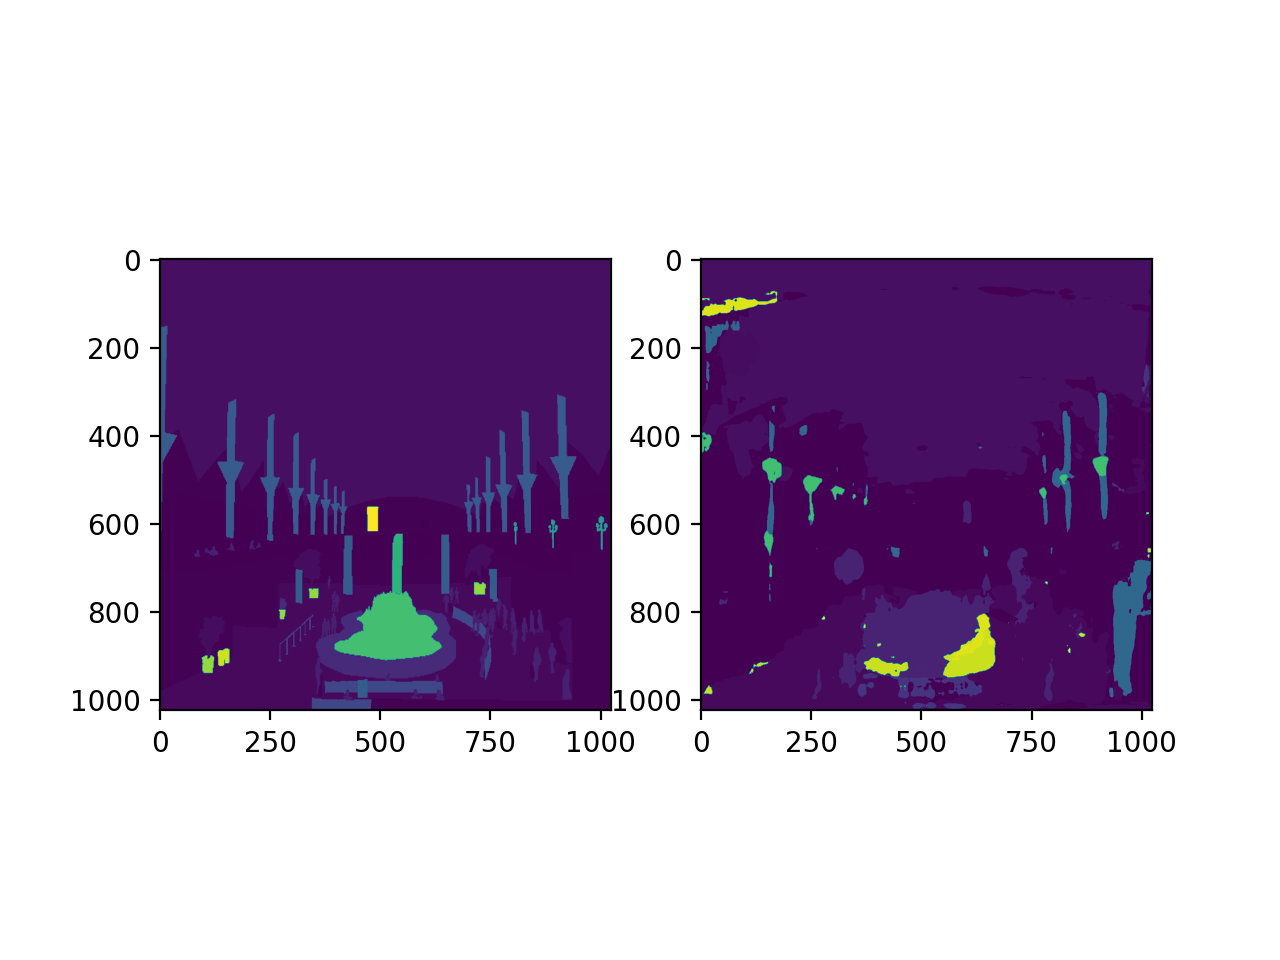

In [16]:
fig, (ax1, ax2)  = plt.subplots(ncols=2)
ax1.imshow(mask)
ax2.imshow(semantic_segmentation[0].cpu())